# Hyperparameter Tuning using HyperDrive

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [22]:
from azureml.core import Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Model

from azureml.train.hyperdrive import MedianStoppingPolicy, RandomParameterSampling, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.dnn import TensorFlow
from azureml.train.hyperdrive.parameter_expressions import uniform, choice
from azureml.widgets import RunDetails

import matplotlib.pyplot as plt
import numpy as np

## Dataset

TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [2]:
ws = Workspace.from_config()
experiment_name = 'covid-pneumonia-hyperdrive'

experiment=Experiment(ws, experiment_name)

compute_name = "compute-cluster"
vm_size = "STANDARD_NC6"

try:
    compute_cluster = ComputeTarget(workspace=ws, name=compute_name)
    print("Found existing cluster, using it!")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size=vm_size, max_nodes=6)
    compute_cluster = ComputeTarget.create(ws, compute_name, compute_config)
    compute_cluster.wait_for_completion()

Found existing cluster, using it!


In [19]:
from azureml.data.dataset_factory import FileDatasetFactory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def register_data():
    data = FileDatasetFactory.upload_directory("./Covid19-dataset/",target=ws.get_default_datastore())    
    print("type:",type(data))
    
    data.register(ws, "covid-pneumonia-dataset")
    #data.download(target_path="./downloaded_data", overwrite=False)

    return data
        
register_data()

Method upload_directory: This is an experimental method, and may change at any time.<br/>For more information, see https://aka.ms/azuremlexperimental.


Validating arguments.
Arguments validated.
Uploading file to /
Uploading an estimated of 317 files
Target already exists. Skipping upload for test/Covid/0100.jpeg
Target already exists. Skipping upload for test/Covid/0102.jpeg
Target already exists. Skipping upload for test/Covid/0105.png
Target already exists. Skipping upload for test/Covid/0106.jpeg
Target already exists. Skipping upload for test/Covid/0108.jpeg
Target already exists. Skipping upload for test/Covid/0111.jpg
Target already exists. Skipping upload for test/Covid/0112.jpg
Target already exists. Skipping upload for test/Covid/0113.jpg
Target already exists. Skipping upload for test/Covid/0115.jpeg
Target already exists. Skipping upload for test/Covid/0118.jpeg
Target already exists. Skipping upload for test/Covid/0119.jpeg
Target already exists. Skipping upload for test/Covid/0120.jpg
Target already exists. Skipping upload for test/Covid/094.png
Target already exists. Skipping upload for test/Covid/096.png
Target already

Target already exists. Skipping upload for train/Covid/079.jpeg
Target already exists. Skipping upload for train/Covid/08.jpeg
Target already exists. Skipping upload for train/Covid/080.jpg
Target already exists. Skipping upload for train/Covid/081.jpeg
Target already exists. Skipping upload for train/Covid/082.jpg
Target already exists. Skipping upload for train/Covid/083.jpeg
Target already exists. Skipping upload for train/Covid/084.jpeg
Target already exists. Skipping upload for train/Covid/085.jpeg
Target already exists. Skipping upload for train/Covid/086.jpg
Target already exists. Skipping upload for train/Covid/088.jpeg
Target already exists. Skipping upload for train/Covid/089.jpg
Target already exists. Skipping upload for train/Covid/09.png
Target already exists. Skipping upload for train/Covid/090.jpeg
Target already exists. Skipping upload for train/Covid/091.jpg
Target already exists. Skipping upload for train/Covid/092.png
Target already exists. Skipping upload for train/

Target already exists. Skipping upload for train/Viral Pneumonia/010.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/011.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/012.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/013.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/016.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/018.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/019.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/02.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/020.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/021.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/022.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/023.jpeg
Target already exists. Skipping upload for train/Viral Pneumonia/024.jpeg
Target already exists. Skipping upload 

{
  "source": [
    "('workspaceblobstore', '')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ]
}

Found 251 images belonging to 3 classes.


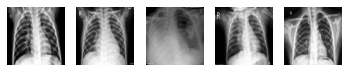

In [30]:
# def plot_data(image_generator):
    
#     batch = next(image_generator)[0]
    
#     num_images = batch.shape[0]
#     cols = min(5,num_images)
    
#     fig, ax = plt.subplots(nrows=1, ncols=cols)

#     for i in range(cols):
#         image = batch[i]
#         ax[i].imshow(image)
#         ax[i].axis('off')
        
# gen = get_data()
# plot_data(gen)

## Hyperdrive Configuration

TODO: Explain the model you are using and the reason for chosing the different hyperparameters, termination policy and config settings.

In [ ]:
# TODO: Create an early termination policy. This is not required if you are using Bayesian sampling.
early_termination_policy = MedianStoppingPolicy(evaluation_interval=25, delay_evaluation=10)

#TODO: Create the different params that you will be using during training
param_sampling = RandomParameterSampling({'filter1': choice([16, 32, 64, 96, 128]),
                                          'filter2': choice([16, 32, 64, 96, 128]),
                                          'filter3': choice(range(16,129)),
                                          'epochs': choice(range(10,61,5)),
                                          'dense_units': choice([16,32,64,96,128,192]),
                                          'dropout': uniform(0.2, 0.5)})

#TODO: Create your estimator and hyperdrive config
estimator = Tensorflow(source_directory='./', compute_target=compute_cluster, vm_size=vm_size, entry_script='./main.py')

hyperdrive_run_config = HyperDriveConfig(hyperparameter_sampling = param_sampling,
                                         estimator = estimator,
                                         policy = early_termination_policy,
                                         primary_metric_name = 'accuracy',
                                         primary_metric_goal = PrimaryMetricGoal.MAXIMIZE,
                                         max_total_runs = 50,
                                         max_concurrent_runs = 5)

In [ ]:
#TODO: Submit your experiment
hyperdrive_run = experiment.submit(hyperdrive_run_config)

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [ ]:
RunDetails(hyperdrive_run).show()
hyperdrive_run.wait_for_completion()

## Best Model

TODO: In the cell below, get the best model from the hyperdrive experiments and display all the properties of the model.

In [ ]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_metrics = best_run.get_metrics()
best_parameters = best_run.get_details()['runDefinition']['arguments']

print("Best Run:",best_run.id)
print("Accuracy:",best_run_metrics['accuracy'])
print("Parameters:")
for i in range(0,len(best_parameters),2):
    print(best_parameters[i],"-",best_parameters[i+1])

In [ ]:
#TODO: Save the best model
os.makedirs("downloadedModel", exist_ok=True)
best_run.download_file(name = './outputs/model', output_file_path = "downloadedModel")

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [ ]:
registered_model = best_run.register_model(model_name='covid-pneumonia-cnn',
                                           model_path='./outputs/model',
                                           model_framework=Model.Framework.TENSORFLOW,
                                           model_framework_version='2.0')

TODO: In the cell below, send a request to the web service you deployed to test it.

TODO: In the cell below, print the logs of the web service and delete the service